# Submission 2

Datasets Description (need to be added)



In [1]:
#pip install holidays

In [2]:
import arch
import holidays
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, coint # for ADF and Cointegration
from statsmodels.tsa.vector_ar.vecm import VECM
%matplotlib inline

## Importing Datasets and making them time consistent

In [3]:
gld_df = pd.read_csv("GLD.csv")
ety_df = pd.read_csv("2833.HK.csv")
btc_df = pd.read_csv("BTC-USD.csv")

In [4]:
len(gld_df), len(ety_df), len(btc_df)

(252, 247, 366)

In [5]:
# to make the analysis consistent let's first make the datetime consistent for each of the three time series, 
#starting with creating datetime index

In [6]:
# the function takes the date column of the dataset and convert it into index of the dataframe
def dtindex(df):
    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")
    df.set_index("Date", inplace=True)   
    return df

In [7]:
gld_df = dtindex(gld_df)
ety_df = dtindex(ety_df)
btc_df = dtindex(btc_df)

In [8]:
index1 = set(ety_df.index)
index2 = set(gld_df.index)
gap = index1-index2
len(index1), len(index2), len(gap)

(247, 252, 6)

In [9]:
print(gap)

{Timestamp('2020-07-03 00:00:00'), Timestamp('2020-11-26 00:00:00'), Timestamp('2020-05-25 00:00:00'), Timestamp('2020-02-17 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-01-20 00:00:00')}


In [10]:
# defining function that takes only common index across the 3 time series data 
def consis_index(df, indices, missing):
    return df.loc[[index for index in indices if index not in missing]]

In [11]:
gld_df = consis_index(gld_df, ety_df.index, gap)
ety_df = consis_index(ety_df, ety_df.index, gap)
btc_df = consis_index(btc_df, ety_df.index, gap)

In [12]:
len(gld_df), len(ety_df), len(btc_df)

(241, 241, 241)

In [13]:
# looking at the shape of each time series
gld_df.shape, ety_df.shape, btc_df.shape

((241, 6), (241, 6), (241, 6))

In [14]:
ety_df["Day_Return"] = ety_df["Adj Close"].pct_change(1)
gld_df["Day_Return"] = gld_df["Adj Close"].pct_change(1)
btc_df["Day_Return"] = btc_df["Adj Close"].pct_change(1)

In [15]:
ety_df.head()

,Open,High,Low,Close,Adj Close,Volume,Day_Return
Date,,,,,,,
2020-01-02,28.750000,29.000000,28.600000,28.950001,28.950001,50060,NaN
2020-01-03,29.049999,29.299999,28.850000,28.900000,28.900000,73200,-0.001727
2020-01-06,28.750000,28.750000,28.450001,28.600000,28.600000,129327,-0.010381
2020-01-07,28.750000,28.950001,28.750000,28.750000,28.750000,21600,0.005245
2020-01-08,28.100000,28.650000,28.100000,28.400000,28.400000,120876,-0.012174


In [16]:
ety_df.tail()

,Open,High,Low,Close,Adj Close,Volume,Day_Return
Date,,,,,,,
2020-12-23,26.500000,26.740000,26.500000,26.740000,26.740000,25600,0.008296
2020-12-24,26.820000,26.820000,26.820000,26.820000,26.820000,0,0.002992
2020-12-28,26.820000,26.959999,26.740000,26.780001,26.780001,60000,-0.001491
2020-12-29,26.860001,27.020000,26.860001,27.000000,27.000000,48128,0.008215
2020-12-30,27.000000,27.600000,27.000000,27.600000,27.600000,350172,0.022222


## Data Processing 


In [17]:
#Importing data for April to December period
ety_AD = ety_df[(ety_df.index >= "2020-04-01") & (ety_df.index < "2020-12-31")]

In [18]:
ety_AD.head()

,Open,High,Low,Close,Adj Close,Volume,Day_Return
Date,,,,,,,
2020-04-01,24.299999,24.400000,23.549999,23.600000,23.600000,116900,-0.030801
2020-04-02,23.450001,23.799999,23.299999,23.799999,23.799999,54400,0.008475
2020-04-03,23.900000,23.900000,23.500000,23.650000,23.650000,46400,-0.006302
2020-04-06,23.900000,24.350000,23.850000,24.299999,24.299999,57400,0.027484
2020-04-07,24.500000,24.850000,24.350000,24.799999,24.799999,138229,0.020576


In [19]:
gld_AD = gld_df[(gld_df.index >= "2020-04-01") & (gld_df.index < "2020-12-31")]
btc_AD = btc_df[(btc_df.index >= "2020-04-01") & (btc_df.index < "2020-12-31")]

## Data Summaries

In [20]:
# Calculating the moving average [using march data for April moving average]

In [21]:
ety_ma =  ety_df[(ety_df.index >= "2020-03-01") & (ety_df.index < "2020-12-31")]['Adj Close'].rolling(20, min_periods=1).mean()

In [22]:
gld_ma =  gld_df[(gld_df.index >= "2020-03-01") & (gld_df.index < "2020-12-31")]['Adj Close'].rolling(20, min_periods=1).mean()
btc_ma =  btc_df[(btc_df.index >= "2020-03-01") & (btc_df.index < "2020-12-31")]['Adj Close'].rolling(20, min_periods=1).mean()

In [23]:
# taking the MA data for April to Dec
ety_ma = ety_ma[(ety_ma.index >= "2020-04-01") & (ety_ma.index < "2020-12-31")]
gld_ma = gld_ma[(gld_ma.index >= "2020-04-01") & (gld_ma.index < "2020-12-31")]
btc_ma = btc_ma[(btc_ma.index >= "2020-04-01") & (btc_ma.index < "2020-12-31")]

In [24]:
ety_ma.head()

Date
2020-04-01    24.4950
2020-04-02    24.3200
2020-04-03    24.1675
2020-04-06    24.0475
2020-04-07    24.0075
Name: Adj Close, dtype: float64

In [25]:
ety_ma.tail()

Date
2020-12-23    26.935
2020-12-24    26.922
2020-12-28    26.890
2020-12-29    26.898
2020-12-30    26.930
Name: Adj Close, dtype: float64

## Graphing

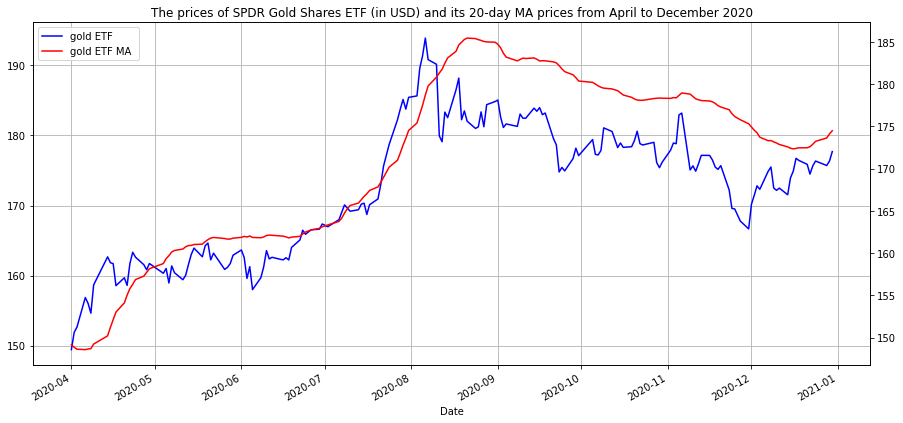

In [26]:
plt.figure(figsize=(15,7))
plt.title('The prices of SPDR Gold Shares ETF (in USD) and its 20-day MA prices from April to December 2020')

ax1 = gld_AD["Adj Close"].plot(color='blue', grid=True, label='gold ETF')
ax2 = gld_ma.plot(color='red', grid=True, secondary_y=True, label='gold ETF MA ')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

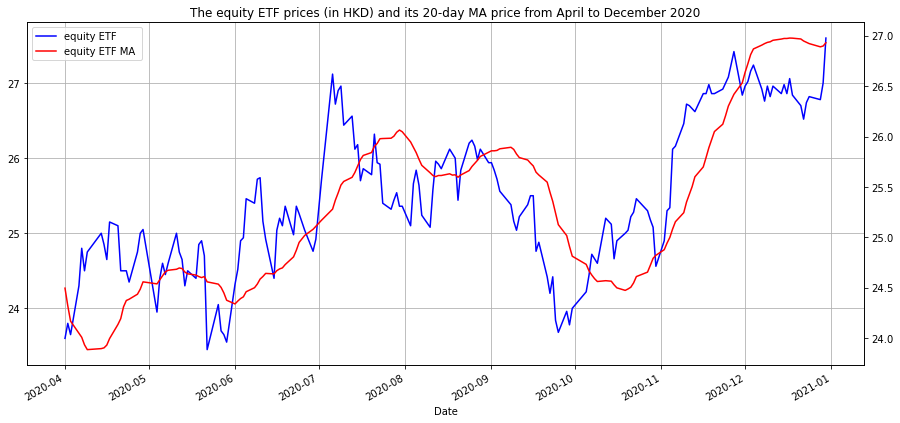

In [27]:
plt.figure(figsize=(15,7))
plt.title('The equity ETF prices (in HKD) and its 20-day MA price from April to December 2020')

ax1 = ety_AD["Adj Close"].plot(color='blue', grid=True, label='equity ETF')
ax2 = ety_ma.plot(color='red', grid=True, secondary_y=True, label='equity ETF MA ')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

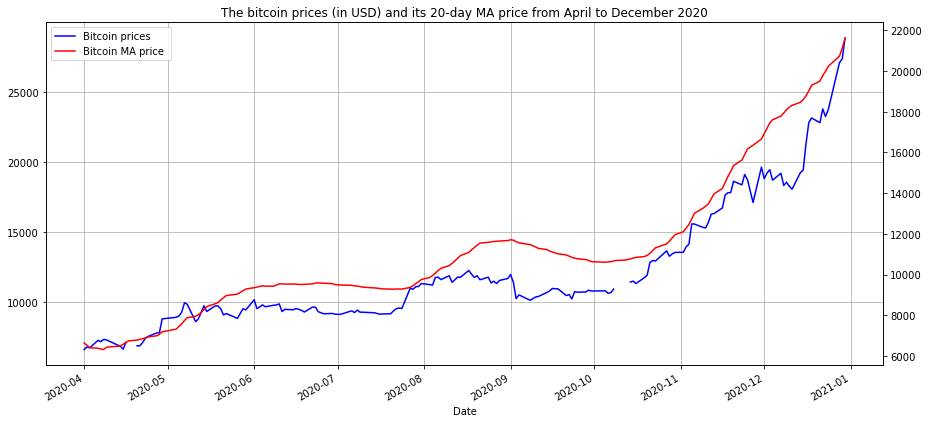

In [28]:
plt.figure(figsize=(15,7))
plt.title('The bitcoin prices (in USD) and its 20-day MA price from April to December 2020')

ax1 = btc_AD["Adj Close"].plot(color='blue', grid=True, label='Bitcoin prices')
ax2 = btc_ma.plot(color='red', grid=True, secondary_y=True, label='Bitcoin MA price ')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

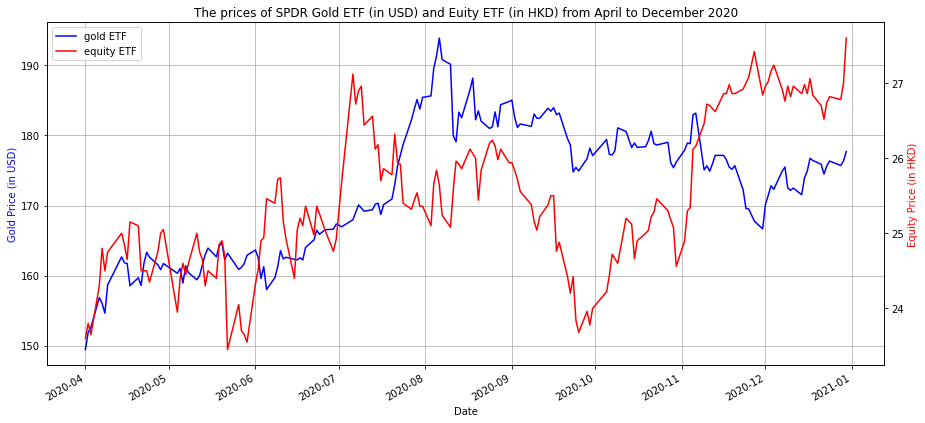

In [29]:
# Graphing Gold and Equity
plt.figure(figsize=(15,7))
plt.title('The prices of SPDR Gold ETF (in USD) and Euity ETF (in HKD) from April to December 2020')

ax1 = gld_AD["Adj Close"].plot(color='blue', grid=True, label='gold ETF')
ax2 = ety_AD["Adj Close"].plot(color='red', grid=True, secondary_y=True, label='equity ETF')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

ax1.set_ylabel('Gold Price (in USD)', color='b')
ax2.set_ylabel('Equity Price (in HKD)', color='r')

plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

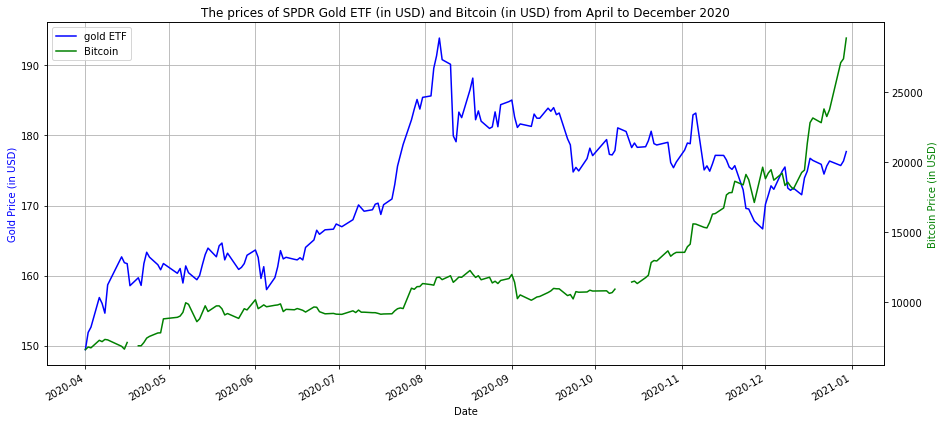

In [30]:
# Graphing Gold and Bitcoin
plt.figure(figsize=(15,7))
plt.title('The prices of SPDR Gold ETF (in USD) and Bitcoin (in USD) from April to December 2020')

ax1 = gld_AD["Adj Close"].plot(color='blue', grid=True, label='gold ETF')
ax2 = btc_AD["Adj Close"].plot(color='green', grid=True, secondary_y=True, label='Bitcoin')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

ax1.set_ylabel('Gold Price (in USD)', color='b')
ax2.set_ylabel('Bitcoin Price (in USD)', color='g')

plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

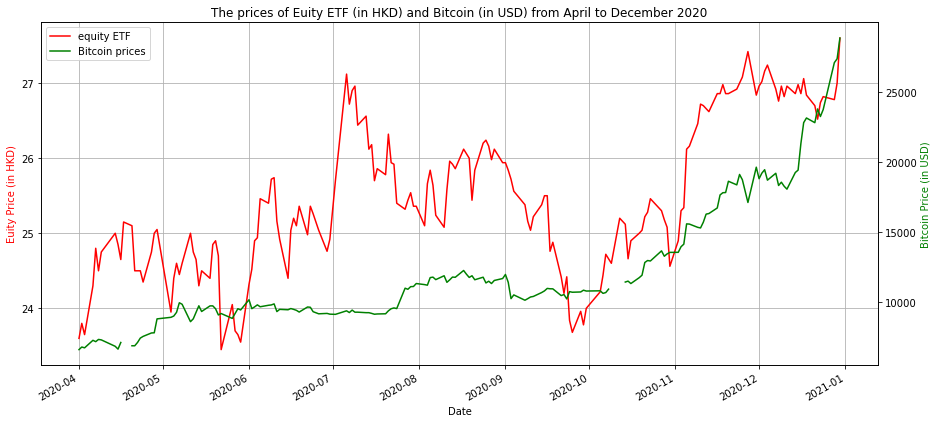

In [31]:
# Graphing Equity ETF and Bitcoin
plt.figure(figsize=(15,7))
plt.title('The prices of Euity ETF (in HKD) and Bitcoin (in USD) from April to December 2020')

ax1 = ety_AD["Adj Close"].plot(color='red', grid=True, label='equity ETF')
ax2 = btc_AD["Adj Close"].plot(color='green', grid=True, secondary_y=True, label='Bitcoin prices')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

ax1.set_ylabel('Euity Price (in HKD)', color='r')
ax2.set_ylabel('Bitcoin Price (in USD)', color='g')

plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

## Fitting GARCH

In [32]:
#We picked equity ETF and Fitting GARCH model for Q2, Q3 and Q4

In [33]:
def fit_garch(data, garch_type="GARCH"):
    if garch_type == "TARCH":
        garch = arch.arch_model(data, vol='GARCH', p=1, o=1, q=1, power=1)
    else:
        garch = arch.arch_model(data, vol=garch_type, p=1, o=0, q=1)
    garch_fitted = garch.fit()
    print(garch_fitted.summary())
    if garch_type != "FIGARCH":
        omega = garch_fitted.params["omega"]
        alpha = garch_fitted.params["alpha[1]"]
        beta = garch_fitted.params["beta[1]"]
        print(f"Unconditional variance: {omega/(1 - alpha - beta)}")

In [34]:
def get_data(df, quarter, column):
    if quarter == 'Q4':
        return df[(df.index > "2020-09-30")][column]
    elif quarter == 'Q3':
        return df.loc[(df.index > "2020-06-30") & (df.index < "2020-10-01")][column]
    elif quarter == 'Q2':
        return df[(df.index > "2020-03-31") & (df.index < "2020-07-01")][column]

In [35]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [36]:
quarter_name = {"Q2": "Quarter 2", "Q3": "Quarter 3", "Q4": "Quarter 4"}

In [37]:
for quarter in ["Q2", "Q3", "Q4"]:
    print(color.BOLD + f"GARCH model for equity in {quarter_name[quarter]}" + color.END)
    data = get_data(ety_AD, quarter, "Day_Return")
    data = data.dropna()
    fit_garch(data)

GARCH model for equity in Quarter 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 25146993.353872925
Iteration:      2,   Func. Count:     17,   Neg. LLF: 30403189.723934203
Iteration:      3,   Func. Count:     24,   Neg. LLF: -159.29642141620857
Iteration:      4,   Func. Count:     29,   Neg. LLF: -85.4695361962525
Iteration:      5,   Func. Count:     37,   Neg. LLF: -159.33513560967793
Iteration:      6,   Func. Count:     42,   Neg. LLF: -159.35510953325561
Iteration:      7,   Func. Count:     47,   Neg. LLF: -159.352366863455
Iteration:      8,   Func. Count:     53,   Neg. LLF: -159.34758621480736
Iteration:      9,   Func. Count:     60,   Neg. LLF: -159.36741939334865
Iteration:     10,   Func. Count:     65,   Neg. LLF: -159.36738405665443
Iteration:     11,   Func. Count:     71,   Neg. LLF: -159.3674015190531
Optimization terminated successfully    (Exit mode 0)
            Current function value: -159.36743037131143
            Iterations: 11
            Function

/Users/vidhanajmera/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002645. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/vidhanajmera/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001883. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/vidhanajmera/opt/anaconda3/lib/

In [38]:
for model in ["GARCH", "EGARCH", "FIGARCH", "TARCH"]:
    for quarter in ["Q2", "Q3", "Q4"]:
        print(color.BOLD + f"{model} model for equity in {quarter_name[quarter]}" + color.END)
        data = get_data(ety_AD, str(quarter), "Day_Return")
        data = data.dropna()
        fit_garch(data, model)

GARCH model for equity in Quarter 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 25146993.353872925
Iteration:      2,   Func. Count:     17,   Neg. LLF: 30403189.723934203
Iteration:      3,   Func. Count:     24,   Neg. LLF: -159.29642141620857
Iteration:      4,   Func. Count:     29,   Neg. LLF: -85.4695361962525
Iteration:      5,   Func. Count:     37,   Neg. LLF: -159.33513560967793
Iteration:      6,   Func. Count:     42,   Neg. LLF: -159.35510953325561
Iteration:      7,   Func. Count:     47,   Neg. LLF: -159.352366863455
Iteration:      8,   Func. Count:     53,   Neg. LLF: -159.34758621480736
Iteration:      9,   Func. Count:     60,   Neg. LLF: -159.36741939334865
Iteration:     10,   Func. Count:     65,   Neg. LLF: -159.36738405665443
Iteration:     11,   Func. Count:     71,   Neg. LLF: -159.3674015190531
Optimization terminated successfully    (Exit mode 0)
            Current function value: -159.36743037131143
            Iterations: 11
            Function

/Users/vidhanajmera/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002645. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/vidhanajmera/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001883. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/vidhanajmera/opt/anaconda3/lib/


Unconditional variance: -1.5061941574840347
FIGARCH model for equity in Quarter 2
Iteration:      1,   Func. Count:      7,   Neg. LLF: 8067851.403064079
Iteration:      2,   Func. Count:     19,   Neg. LLF: -133.49731308969115
Iteration:      3,   Func. Count:     27,   Neg. LLF: -155.69679858367869
Iteration:      4,   Func. Count:     34,   Neg. LLF: -144.3154791444609
Iteration:      5,   Func. Count:     42,   Neg. LLF: 75070334787516.2
Iteration:      6,   Func. Count:     54,   Neg. LLF: 27985889.604877632
Iteration:      7,   Func. Count:     61,   Neg. LLF: -158.62296436799357
Iteration:      8,   Func. Count:     67,   Neg. LLF: -156.16348803141923
Iteration:      9,   Func. Count:     74,   Neg. LLF: 26760992.990802806
Iteration:     10,   Func. Count:     86,   Neg. LLF: 360.7881690305822
Iteration:     11,   Func. Count:     94,   Neg. LLF: 5880.248925977655
Iteration:     12,   Func. Count:    102,   Neg. LLF: 5249.392616591928
Iteration:     13,   Func. Count:    110,  

Covariance estimator: robust
Unconditional variance: 0.018264552311613395
TARCH model for equity in Quarter 4
Iteration:      1,   Func. Count:      7,   Neg. LLF: 527986.8568278211
Iteration:      2,   Func. Count:     19,   Neg. LLF: -59.66928257548492
Iteration:      3,   Func. Count:     28,   Neg. LLF: -156.63547714521113
Iteration:      4,   Func. Count:     35,   Neg. LLF: -188.39736904800603
Iteration:      5,   Func. Count:     42,   Neg. LLF: -191.682345939607
Iteration:      6,   Func. Count:     48,   Neg. LLF: -191.68341886363456
Iteration:      7,   Func. Count:     54,   Neg. LLF: -191.49787004018174
Iteration:      8,   Func. Count:     62,   Neg. LLF: -191.68350703180332
Iteration:      9,   Func. Count:     68,   Neg. LLF: -191.68350860549373
Iteration:     10,   Func. Count:     74,   Neg. LLF: -191.68350948453795
Optimization terminated successfully    (Exit mode 0)
            Current function value: -191.68350948453795
            Iterations: 10
            Functi

/Users/vidhanajmera/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001883. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/vidhanajmera/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.901e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/vidhanajmera/opt/anaconda3/lib/

In [39]:
for model in ["GARCH", "EGARCH", "FIGARCH", "TARCH"]:
    for quarter in ["Q2", "Q3", "Q4"]:
        print(color.BOLD + f"{model} model for gold in {quarter_name[quarter]}" + color.END)
        data = get_data(gld_AD, str(quarter), "Day_Return")
        data = data.dropna()
        fit_garch(data, model)

GARCH model for gold in Quarter 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 253685803.98650953
Iteration:      2,   Func. Count:     17,   Neg. LLF: 3790018.9354595123
Iteration:      3,   Func. Count:     28,   Neg. LLF: 1518793501277.764
Iteration:      4,   Func. Count:     39,   Neg. LLF: 3627.714450820217
Iteration:      5,   Func. Count:     48,   Neg. LLF: 717.2735327079474
Iteration:      6,   Func. Count:     56,   Neg. LLF: 39231563.46517301
Iteration:      7,   Func. Count:     66,   Neg. LLF: -186.6633481691745
Optimization terminated successfully    (Exit mode 0)
            Current function value: -186.66334818441297
            Iterations: 11
            Function evaluations: 66
            Gradient evaluations: 7
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Day_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:  

/Users/vidhanajmera/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000111. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/vidhanajmera/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001553. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/vidhanajmera/opt/anaconda3/lib/p


Unconditional variance: 0.00015529287905849536
GARCH model for gold in Quarter 4
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2412447.964103767
Iteration:      2,   Func. Count:     17,   Neg. LLF: -110.7222961318153
Iteration:      3,   Func. Count:     26,   Neg. LLF: -184.79905337587635
Iteration:      4,   Func. Count:     31,   Neg. LLF: -184.798940538862
Iteration:      5,   Func. Count:     37,   Neg. LLF: -184.89351997719493
Iteration:      6,   Func. Count:     42,   Neg. LLF: 1.6937457983458204e+18
Iteration:      7,   Func. Count:     57,   Neg. LLF: 1.4075914902561205e+20
Iteration:      8,   Func. Count:     72,   Neg. LLF: 80520160872.85919
Iteration:      9,   Func. Count:     83,   Neg. LLF: 76459.2939477332
Iteration:     10,   Func. Count:     94,   Neg. LLF: 259188.3138087504
Iteration:     11,   Func. Count:    104,   Neg. LLF: -184.89605382204516
Optimization terminated successfully    (Exit mode 0)
            Current function value: -184.89605372818136


Covariance estimator: robust
Unconditional variance: -1.9799405715058298
FIGARCH model for gold in Quarter 2
Iteration:      1,   Func. Count:      7,   Neg. LLF: 30675910.664156068
Iteration:      2,   Func. Count:     19,   Neg. LLF: 53171.615925447884
Iteration:      3,   Func. Count:     30,   Neg. LLF: -186.69749868373447
Optimization terminated successfully    (Exit mode 0)
            Current function value: -186.69749873709014
            Iterations: 7
            Function evaluations: 30
            Gradient evaluations: 3
                    Constant Mean - FIGARCH Model Results                     
Dep. Variable:             Day_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                    FIGARCH   Log-Likelihood:                186.697
Distribution:                  Normal   AIC:                          -363.395
Method:            Maximum Likelihood   BIC:                       

/Users/vidhanajmera/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000111. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/vidhanajmera/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/vidhanajmera/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001553. Parameter
estimati


Iteration:      3,   Func. Count:     31,   Neg. LLF: 3582.8822356624823
Iteration:      4,   Func. Count:     43,   Neg. LLF: 653.3331047791692
Iteration:      5,   Func. Count:     53,   Neg. LLF: 53098374.21709014
Iteration:      6,   Func. Count:     65,   Neg. LLF: 642.894606539867
Iteration:      7,   Func. Count:     75,   Neg. LLF: 54.523362372683195
Iteration:      8,   Func. Count:     84,   Neg. LLF: 656489398.4248192
Iteration:      9,   Func. Count:     95,   Neg. LLF: -188.69549524773308
Optimization terminated successfully    (Exit mode 0)
            Current function value: -188.6954951814541
            Iterations: 13
            Function evaluations: 95
            Gradient evaluations: 9
                    Constant Mean - FIGARCH Model Results                     
Dep. Variable:             Day_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                    FIGARCH   Log-Li

/Users/vidhanajmera/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001114. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



FIGARCH model for gold in Quarter 4
Iteration:      1,   Func. Count:      7,   Neg. LLF: 11260261.21946496
Iteration:      2,   Func. Count:     19,   Neg. LLF: -143.0355574810737
Iteration:      3,   Func. Count:     27,   Neg. LLF: -176.49142887452084
Iteration:      4,   Func. Count:     34,   Neg. LLF: -177.0535069590068
Iteration:      5,   Func. Count:     41,   Neg. LLF: -177.71998485106053
Iteration:      6,   Func. Count:     48,   Neg. LLF: -184.67937505356406
Iteration:      7,   Func. Count:     54,   Neg. LLF: -184.74378813059423
Iteration:      8,   Func. Count:     60,   Neg. LLF: 18121.611079986174
Iteration:      9,   Func. Count:     72,   Neg. LLF: -113.63197601986587
Iteration:     10,   Func. Count:     81,   Neg. LLF: -183.13715715610374
Iteration:     11,   Func. Count:     88,   Neg. LLF: -184.49574275895745
Iteration:     12,   Func. Count:     95,   Neg. LLF: -183.87902452713638
Iteration:     13,   Func. Count:    102,   Neg. LLF: -184.00502804565767
Iterat

/Users/vidhanajmera/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000111. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/vidhanajmera/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001553. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/vidhanajmera/opt/anaconda3/lib/p

In [40]:
for model in ["GARCH", "EGARCH", "FIGARCH", "TARCH"]:
    for quarter in ["Q2", "Q3", "Q4"]:
        print(color.BOLD + f"{model} model for Bitcoin in {quarter_name[quarter]}" + color.END)
        data = get_data(btc_AD, str(quarter), "Day_Return")
        data = data.dropna()
        fit_garch(data, model)

GARCH model for Bitcoin in Quarter 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1323070421.645969
Iteration:      2,   Func. Count:     16,   Neg. LLF: 30129764.324057054
Iteration:      3,   Func. Count:     24,   Neg. LLF: -107.1466838356315


/Users/vidhanajmera/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001594. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


ValueError: `x0` violates bound constraints.

## Assesing Stationarity

In [ ]:
for quarter in ["Q2", "Q3", "Q4"]:
    print(f"\033[1m ADF Stationarity test for gold ETF in {quarter_name[quarter]} \033[0m")
    X = get_data(gld_AD, quarter, "Day_Return").values
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[0] < result[4].get("5%"):
        print(f"\x1b[31m we reject the hypothesis that the gold ETF {quarter_name[quarter]} return is non-stationary\x1b[0m")
    else:
        print(f"\033[92m the gold ETF {quarter_name[quarter]} is non-stationary \033[0m")

In [ ]:
for quarter in ["Q2", "Q3", "Q4"]:
    print(f"\033[1m ADF Stationarity test for equity ETF in {quarter_name[quarter]} \033[0m")
    X = get_data(ety_df, quarter, "Day_Return").values
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[0] < result[4].get("5%"):
        print(f"\x1b[31m we reject the hypothesis that the equity ETF {quarter_name[quarter]} return is non-stationary\x1b[0m")
    else:
        print(f"\033[92m the equity ETF {quarter_name[quarter]} is non-stationary \033[0m")

In [ ]:
for quarter in ["Q2", "Q3", "Q4"]:
    print(f"\033[1m ADF Stationarity test for Bitcoin in {quarter_name[quarter]} \033[0m")
    X = get_data(btc_df, quarter, "Day_Return").values
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[0] < result[4].get("5%"):
        print(f"\x1b[31m we reject the hypothesis that the Bitcoin {quarter_name[quarter]} return is non-stationary\x1b[0m")
    else:
        print(f"\033[92m the Bitcoin {quarter_name[quarter]} is non-stationary \033[0m")

## Modelling Cointegration

In [ ]:
# extracting Q2 and Q3 data for gold, equity and bitcoin

In [ ]:
gldQ2_3 = gld_df[(gld_df.index > "2020-03-31") & (gld_df.index < "2020-10-01")]['Day_Return']

In [ ]:
gldQ2_3

In [ ]:
etyQ2_3 = ety_df[(ety_df.index > "2020-03-31") & (ety_df.index < "2020-10-01")]['Day_Return']
btcQ2_3 = btc_df[(btc_df.index > "2020-03-31") & (btc_df.index < "2020-10-01")]['Day_Return']

In [ ]:
len(etyQ2_3), len(btcQ2_3)

In [ ]:
coint_gld_equity = coint(gldQ2_3, etyQ2_3)
print(coint_gld_equity)

In [ ]:
coint_equity_bitcoin = coint(etyQ2_3, btcQ2_3)
print(coint_equity_bitcoin)

In [ ]:
coint_bitcoin_gld = coint(btcQ2_3, gldQ2_3)
print(coint_bitcoin_gld)

In [ ]:
gld_ety = pd.concat([gldQ2_3, etyQ2_3], axis = 1)

In [ ]:
# first importing cointegration johansen module
from statsmodels.tsa.vector_ar.vecm import coint_johansen
coint_gld_equity = coint_johansen(pd.concat([gldQ2_3, etyQ2_3], axis = 1), det_order=0, k_ar_diff=1)
print(coint_gld_equity)

In [ ]:
def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')

In [ ]:
joh_output(coint_gld_equity)

In [ ]:
coint_equity_bitcoin = coint_johansen(pd.concat([btcQ2_3, etyQ2_3], axis = 1), det_order=0, k_ar_diff=1)
joh_output(coint_equity_bitcoin)

In [ ]:
coint_gld_bitcoin = coint_johansen(pd.concat([btcQ2_3, gldQ2_3], axis = 1), det_order=0, k_ar_diff=1)
joh_output(coint_gld_bitcoin)

In [ ]:
data = np.array([gldQ2_3.values, etyQ2_3.values]).T
model = VECM(data, coint_rank=1)
vecm_res = model.fit()
vecm_res.gamma.round(4)
vecm_res.summary()
forecast, lower, upper = vecm_res.predict(5, 0.05)
print("lower bounds of confidence intervals:")
print(lower.round(3))
print("\npoint forecasts:")
print(forecast.round(3))
print("\nupper bounds of confidence intervals:")
print(upper.round(3))
vecm_res.plot_forecast(steps=10)

In [ ]:
data = np.array([etyQ2_3.values, btcQ2_3.values]).T
model = VECM(data, coint_rank=1)
vecm_res = model.fit()
vecm_res.gamma.round(4)
vecm_res.summary()
forecast, lower, upper = vecm_res.predict(5, 0.05)
print("lower bounds of confidence intervals:")
print(lower.round(3))
print("\npoint forecasts:")
print(forecast.round(3))
print("\nupper bounds of confidence intervals:")
print(upper.round(3))
vecm_res.plot_forecast(steps=10)

In [ ]:
data = np.array([btcQ2_3.values, gldQ2_3.values]).T
model = VECM(data, coint_rank=1)
vecm_res = model.fit()
vecm_res.gamma.round(4)
vecm_res.summary()
forecast, lower, upper = vecm_res.predict(5, 0.05)
print("lower bounds of confidence intervals:")
print(lower.round(3))
print("\npoint forecasts:")
print(forecast.round(3))
print("\nupper bounds of confidence intervals:")
print(upper.round(3))
vecm_res.plot_forecast(steps=10)

In [ ]:
from statsmodels.tsa.api import VAR

In [ ]:
data = np.array([gldQ2_3.values, etyQ2_3.values]).T
model = VAR(data)
results = model.fit()
results.summary()

In [ ]:
results.plot_forecast(10)

In [ ]:
data = np.array([gldQ2_3.values, btcQ2_3.values]).T
model = VAR(data)
results = model.fit()
print(results.summary())
results.plot_forecast(10)

In [ ]:
data = np.array([etyQ2_3.values, btcQ2_3.values]).T
model = VAR(data)
results = model.fit()
print(results.summary())
results.plot_forecast(10)

In [ ]:
# Performing VECM and VAR using the 3 datasets together

In [ ]:
data = np.array([gldQ2_3.values, etyQ2_3.values, btcQ2_3.values]).T
model = VECM(data, coint_rank=1)
vecm_res = model.fit()
vecm_res.gamma.round(4)
vecm_res.summary()
forecast, lower, upper = vecm_res.predict(5, 0.05)
print("lower bounds of confidence intervals:")
print(lower.round(3))
print("\npoint forecasts:")
print(forecast.round(3))
print("\nupper bounds of confidence intervals:")
print(upper.round(3))
vecm_res.plot_forecast(steps=10)

In [ ]:
data = np.array([etyQ2_3.values, gldQ2_3.values, btcQ2_3.values]).T
model = VAR(data)
results = model.fit()
print(results.summary())
results.plot_forecast(10)